# Detailed Analysis
This analysis is the further work based off the cleaned data in the EDA notebook.


In [466]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

In [467]:
#Extract data from MsSQL server - accessed through a DSN connection
df = pd.read_csv('CSDA1050_CL_Cleaned.csv')
df.head(5)

Unnamed: 0    area  bedrooms             datetime   price  url   latitude  \
0       14418  1300.0       3.0  2019-03-19 08:35:00  2550.0  NaN  43.676357   
1       14417   750.0       2.0  2019-03-19 08:38:00  2600.0  NaN  43.685689   
2       14416   950.0       2.0  2019-03-19 08:40:00  2650.0  NaN  43.663550   
3       14415  1000.0       2.0  2019-03-19 09:19:00  4978.0  NaN  43.659319   
4       14414     NaN       2.0  2019-03-19 09:22:00  3250.0  NaN  43.646728   

   longitude  outlier   ppbrm    ppsqft title_txt body_txt title_cln body_cln  \
0 -79.293031    False   850.0  1.961538       NaN      NaN       NaN      NaN   
1 -79.312877    False  1300.0  3.466667       NaN      NaN       NaN      NaN   
2 -79.341209    False  1325.0  2.789474       NaN      NaN       NaN      NaN   
3 -79.385182    False  2489.0  4.978000       NaN      NaN       NaN      NaN   
4 -79.391226    False  1625.0       NaN       NaN      NaN       NaN      NaN   

   title_snt  body_snt  basement  studio  listbdrm  
0        NaN       NaN     False   False       3.0  
1        NaN       NaN     False   False       2.0  
2        NaN       NaN     False   False       2.0  
3        NaN       NaN     False   False       2.0  
4        NaN       NaN     False   False       2.0

## Location Analysis

In [468]:
# set the filepath and load in a shapefile
fp = 'neighbourhoods_planning_areas_wgs84/NEIGHBORHOODS_WGS84.shp'

map_df = gpd.read_file(fp)
print(map_df.crs)
# map_df=map_df.to_crs({'init': 'epsg:2019'})

{'init': 'epsg:4326'}


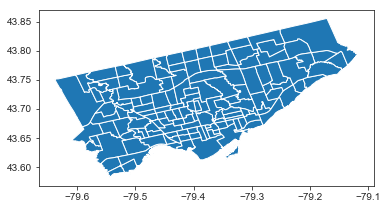

In [469]:
#Preview shapefile
map_df.plot()

In [470]:
#Format Lat/lon correctly for plotting
df['coordinates']=list(zip(df.longitude, df.latitude))
df['coordinates'] = df['coordinates'].apply(Point)
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(df, crs=crs,geometry='coordinates')
gdf.head()

Unnamed: 0    area  bedrooms             datetime   price  url   latitude  \
0       14418  1300.0       3.0  2019-03-19 08:35:00  2550.0  NaN  43.676357   
1       14417   750.0       2.0  2019-03-19 08:38:00  2600.0  NaN  43.685689   
2       14416   950.0       2.0  2019-03-19 08:40:00  2650.0  NaN  43.663550   
3       14415  1000.0       2.0  2019-03-19 09:19:00  4978.0  NaN  43.659319   
4       14414     NaN       2.0  2019-03-19 09:22:00  3250.0  NaN  43.646728   

   longitude  outlier   ppbrm  ...  title_txt body_txt title_cln body_cln  \
0 -79.293031    False   850.0  ...        NaN      NaN       NaN      NaN   
1 -79.312877    False  1300.0  ...        NaN      NaN       NaN      NaN   
2 -79.341209    False  1325.0  ...        NaN      NaN       NaN      NaN   
3 -79.385182    False  2489.0  ...        NaN      NaN       NaN      NaN   
4 -79.391226    False  1625.0  ...        NaN      NaN       NaN      NaN   

  title_snt  body_snt  basement  studio  listbdrm  \
0       NaN       NaN     False   False       3.0   
1       NaN       NaN     False   False       2.0   
2       NaN       NaN     False   False       2.0   
3       NaN       NaN     False   False       2.0   
4       NaN       NaN     False   False       2.0   

                           coordinates  
0         POINT (-79.293031 43.676357)  
1         POINT (-79.312877 43.685689)  
2  POINT (-79.34120899999999 43.66355)  
3         POINT (-79.385182 43.659319)  
4         POINT (-79.391226 43.646728)  

[5 rows x 21 columns]

In [471]:
#Calculate PPBRM and PPSQFT for each neighborhood of Toronto
#aggregate for all data, then filtered by bedroom count in listing

#Do analysis for bedroom counts all and 1-4
bedrooms = [1,2,3,4]

####Create GDF for all bedrooms count####
#sjoin to link data to neighborhoods
pointInPoly = gpd.sjoin(gdf, map_df, op='within') 

#aggregate overall data by neighborhood
tmp_ppbrm = pointInPoly.groupby('AREA_NAME')['ppbrm'].median()
tmp_ppsqft = pointInPoly.groupby('AREA_NAME')['ppsqft'].median()
tmp_bedrooms= pointInPoly.groupby('AREA_NAME')['bedrooms'].mean()

#join to shapefile
map_df_tmpa=map_df.merge(tmp_ppbrm, on='AREA_NAME')
map_df_tmpa=map_df_tmpa.merge(tmp_ppsqft, on='AREA_NAME')
map_df_tmpa=map_df_tmpa.merge(tmp_bedrooms, on='AREA_NAME')
map_df_tmpa['listbdrmcount'] = 'all'

#Store in map_df2
map_df2 = map_df_tmpa

#Repeate for all bedroom counts
for i in bedrooms:
    #sjoin to link data to neighborhoods
    pointInPoly = gpd.sjoin(gdf[gdf.bedrooms==i], map_df, op='within') 

    #aggregate overall data by neighborhood
    tmp_ppbrm = pointInPoly.groupby('AREA_NAME')['ppbrm'].median()
    tmp_ppsqft=pointInPoly.groupby('AREA_NAME')['ppsqft'].median()
    tmp_bedrooms=pointInPoly.groupby('AREA_NAME')['bedrooms'].mean()

    #join to shapefile
    map_df_tmp=map_df.merge(tmp_ppbrm, on='AREA_NAME')
    map_df_tmp=map_df_tmp.merge(tmp_ppsqft, on='AREA_NAME')
    map_df_tmp=map_df_tmp.merge(tmp_bedrooms, on='AREA_NAME')
    map_df_tmp['listbdrmcount'] = i
    
    #append to map_df2 
    map_df2=map_df2.append(map_df_tmp)


#fill NA with 0's
map_df2['ppbrm'].fillna(0, inplace=True)
map_df2['ppsqft'].fillna(0, inplace=True)
map_df2['bedrooms'].fillna(0, inplace=True)
map_df2.crs = map_df.crs

C:\Users\mparravani\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


In [472]:
print(map_df2.crs)
map_df2 = gpd.GeoDataFrame(map_df2, crs=crs,geometry='geometry')
map_df2 = map_df2.to_crs({'init':'epsg:2019'})

{'init': 'epsg:4326'}


In [473]:
#Convert CRS to MTM Zone 10 (https://epsg.io/7991)
# map_df = map_df.to_crs(epsg=7991)
gdf['coordinates']=gdf['coordinates'].to_crs(epsg=2019)

In [474]:
map_df2.head()

AREA_S_CD                     AREA_NAME  \
0       097           Yonge-St.Clair (97)   
1       027  York University Heights (27)   
2       038         Lansing-Westgate (38)   
3       031       Yorkdale-Glen Park (31)   
4       016      Stonegate-Queensway (16)   

                                            geometry    ppbrm    ppsqft  \
0  POLYGON ((313572.832275433 4837693.591162446, ...  2000.00  2.800000   
1  POLYGON ((304374.1999541915 4846441.25135292, ...  1475.00  3.993056   
2  POLYGON ((309632.5212703118 4846630.090700979,...  1491.25  3.071184   
3  POLYGON ((309660.95786051 4840414.596033789, 3...  1800.00  2.923077   
4  POLYGON ((305395.276477816 4833950.152376727, ...  1750.00  1.807692   

   bedrooms listbdrmcount  
0  1.711111           all  
1  1.142857           all  
2  1.852941           all  
3  1.510638           all  
4  1.460000           all

In [475]:
#Rotate map to be better visually represented
map_df2['geometry']=map_df2['geometry'].rotate(angle = -17, origin=(315000,4840000), use_radians=False)
gdf['coordinates']=gdf['coordinates'].rotate(angle = -17, origin=(315000,4840000), use_radians=False)
map_df2.head()

AREA_S_CD                     AREA_NAME  \
0       097           Yonge-St.Clair (97)   
1       027  York University Heights (27)   
2       038         Lansing-Westgate (38)   
3       031       Yorkdale-Glen Park (31)   
4       016      Stonegate-Queensway (16)   

                                            geometry    ppbrm    ppsqft  \
0  POLYGON ((312960.8640338166 4838211.633720009,...  2000.00  2.800000   
1  POLYGON ((306721.736518882 4849266.482576586, ...  1475.00  3.993056   
2  POLYGON ((311805.5054839805 4847909.686176075,...  1491.25  3.071184   
3  POLYGON ((310015.4647588888 4841957.465010825,...  1800.00  2.923077   
4  POLYGON ((304046.1529530964 4837022.651334584,...  1750.00  1.807692   

   bedrooms listbdrmcount  
0  1.711111           all  
1  1.142857           all  
2  1.852941           all  
3  1.510638           all  
4  1.460000           all

In [476]:
gdf['longitude'] = gdf.coordinates.x
gdf['latitude'] = gdf.coordinates.y

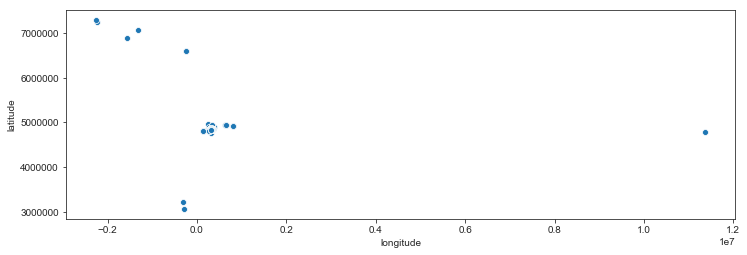

In [477]:
#plot all listings
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
map_df2[map_df2.listbdrmcount == 'all'].plot(ax=ax, color='gray',alpha = 0.4,)
sns.scatterplot("longitude", "latitude", data=gdf)
plt.show()


Clearly there are some wrongly labeled lat/long data points - anything outside of the cluster should be ignored

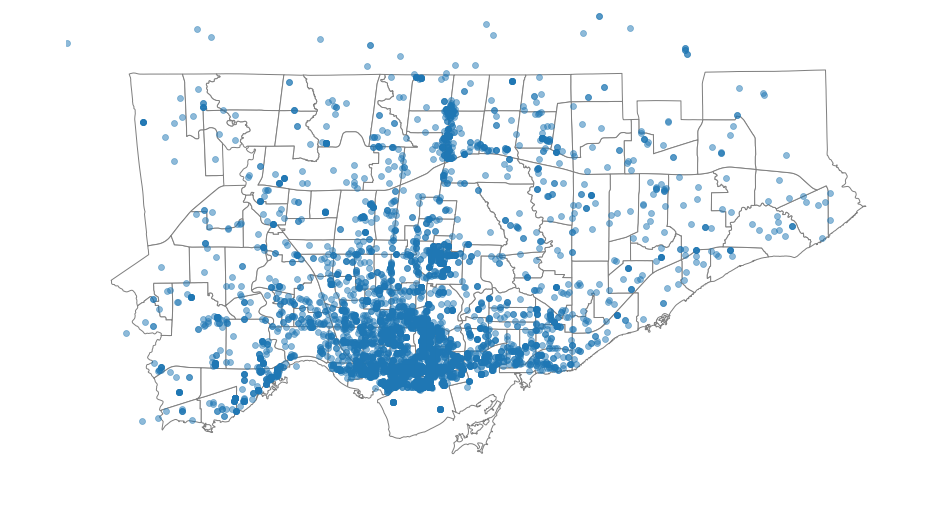

In [478]:
#plot all listings
xlim = (292500,340000)
ylim = (4828000,4855000)

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
map_df2[map_df2.listbdrmcount == 'all'].plot(ax=ax, color='white',edgecolor = 'grey')
sns.scatterplot("longitude", "latitude", data=gdf,edgecolor = None ,alpha = 0.5)
plt.xlim(xlim)
plt.ylim(ylim)
ax.axis('off')
plt.show()

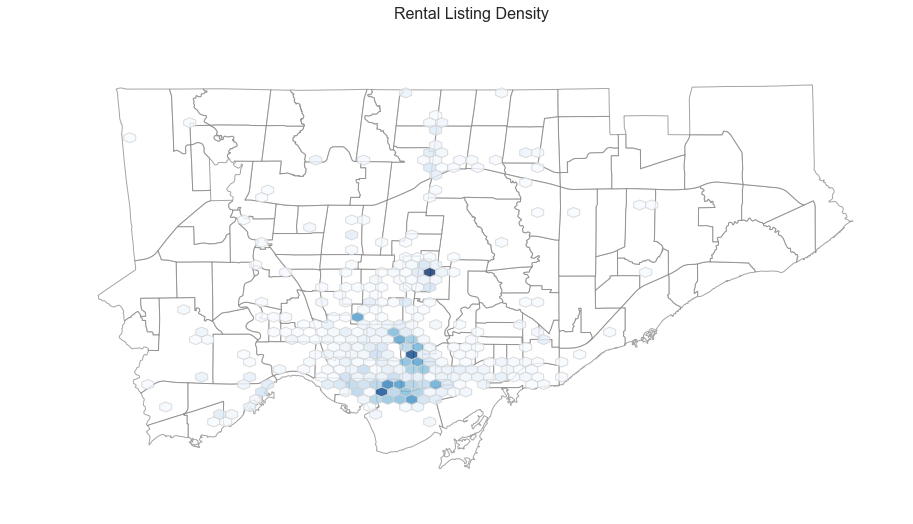

In [479]:
#this is quite busy, lets try it with a hex_bin plot
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
map_df2[map_df2.listbdrmcount == 'all'].plot(ax=ax, color='white',edgecolor = 'grey',alpha = 0.7,)
plt.hexbin(gdf.longitude, gdf.latitude, gridsize=(20000,5000),alpha=0.8,mincnt=5,edgecolors='lightgrey',cmap='Blues' )
plt.xlim(xlim)
plt.ylim(ylim)
ax.axis('off')
plt.title('Rental Listing Density',fontsize=16)
plt.show()


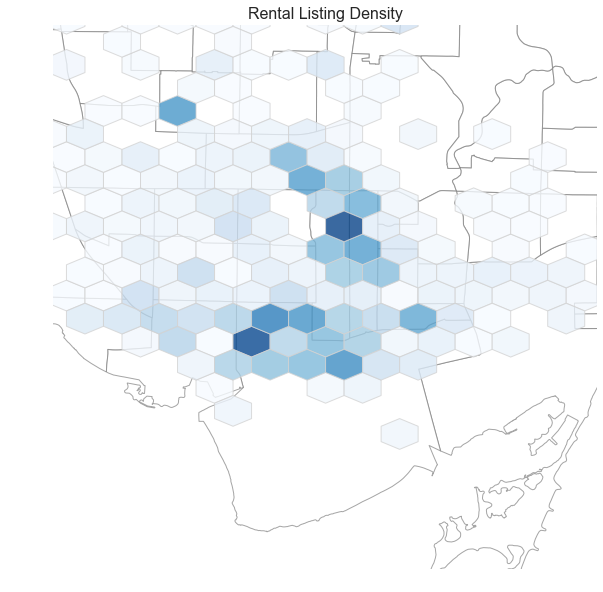

In [480]:
#Lets zoom into the downtown core
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
map_df2[map_df2.listbdrmcount == 'all'].plot(ax=ax, color='white',edgecolor = 'grey',alpha = 0.7,)
plt.hexbin(gdf.longitude, gdf.latitude, gridsize=(20000,5000),alpha = 0.8,mincnt=5,edgecolors='lightgrey',cmap='Blues')
plt.xlim(307500,317500)
plt.ylim(4830000,4840000)
plt.title('Rental Listing Density',fontsize=16)
ax.axis('off')
plt.show()

Highest prices seem to be in the downtown core, and up yonge street. Scarborough seems to have the lowest price per bedroom. This could be a function of bedroom count per listing as well. 

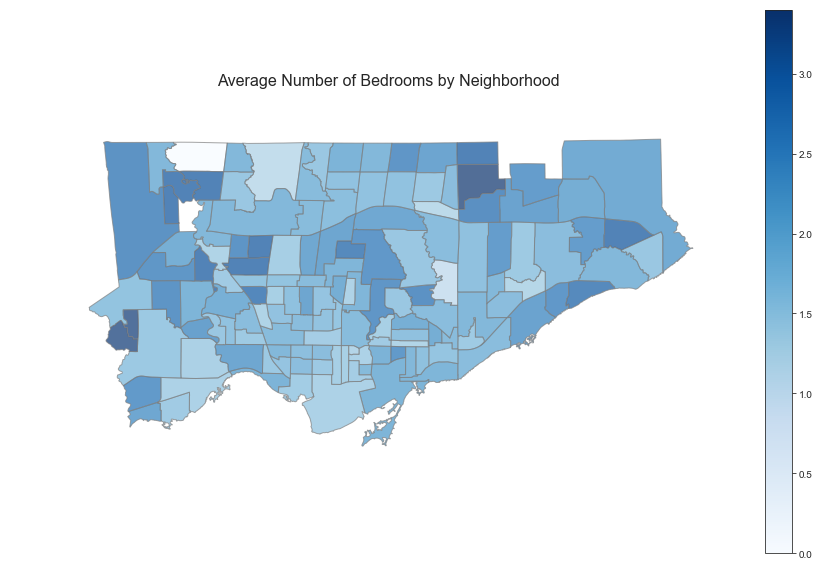

In [481]:
#Plot average number of bedrooms
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
map_df2[map_df2.listbdrmcount == 'all'].plot(ax=ax, column = 'bedrooms',edgecolor = 'grey',alpha = 0.7,cmap='Blues',legend=True)
plt.xlim(xlim)
plt.ylim(ylim)
plt.title('Average Number of Bedrooms by Neighborhood',fontsize=16)
ax.axis('off')
plt.show()

The highest prices were in the downtown core, and those areas look to generally have 1 bedroom units. From earlier in the analysis, 1 bedroom units were generally higher priced on a per/bedroom cost. 

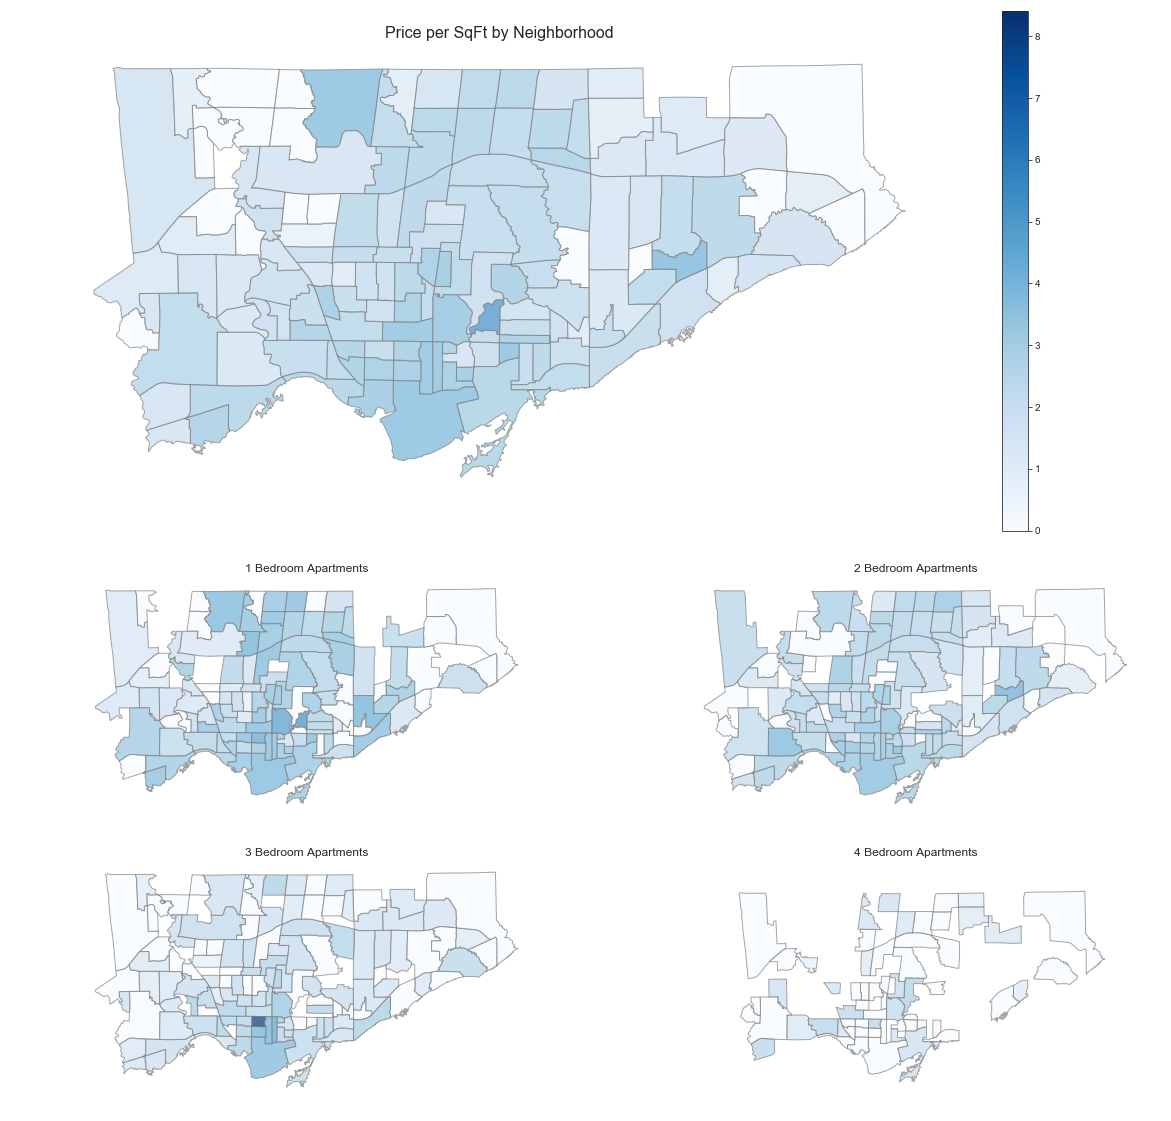

In [482]:
###Set up plot for Price Per Sqft###

#Set gridsize and figure
gridsize = (4, 2)

fig = plt.figure(figsize=(20,20))

#establish consistent scale for all plots
scale_min = np.min(map_df2.ppsqft)
scale_max = np.max(map_df2.ppsqft)

#Set up axes - main plot being the "all bedroom" plot, with subplots for 1,2,etc bedrooms
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid(gridsize, (2, 0))
ax3 = plt.subplot2grid(gridsize, (2, 1))
ax4 = plt.subplot2grid(gridsize, (3, 0))
ax5 = plt.subplot2grid(gridsize, (3, 1))

#Main plot
map_df2[map_df2.listbdrmcount == 'all'].plot(ax = ax1, vmin= scale_min, vmax = scale_max, column = 'ppsqft',edgecolor = 'grey',alpha = 0.7,cmap='Blues', legend = True)
plt.xlim(xlim)
plt.ylim(ylim)
ax1.axis('off')
ax1.set_title('Price per SqFt by Neighborhood',fontsize=16)

#filtered for 1-4 bedroom plots
map_df2[map_df2.listbdrmcount == 1].plot(ax = ax2, vmin= scale_min, vmax = scale_max, column = 'ppsqft',edgecolor = 'grey',alpha = 0.7,cmap='Blues')
plt.xlim(xlim)
plt.ylim(ylim)
ax2.axis('off')
ax2.set_title('1 Bedroom Apartments',fontsize = 12)

map_df2[map_df2.listbdrmcount == 2].plot(ax = ax3, vmin= scale_min, vmax = scale_max, column = 'ppsqft',edgecolor = 'grey',alpha = 0.7,cmap='Blues')
plt.xlim(xlim)
plt.ylim(ylim)
ax3.axis('off')
ax3.set_title('2 Bedroom Apartments',fontsize = 12)
                       
map_df2[map_df2.listbdrmcount == 3].plot(ax = ax4, vmin= scale_min, vmax = scale_max, column = 'ppsqft',edgecolor = 'grey',alpha = 0.7,cmap='Blues')
plt.xlim(xlim)
plt.ylim(ylim)
ax4.axis('off')
ax4.set_title('3 Bedroom Apartments',fontsize = 12)
                       
map_df2[map_df2.listbdrmcount == 4].plot(ax = ax5, vmin= scale_min, vmax = scale_max, column = 'ppsqft',edgecolor = 'grey',alpha = 0.7,cmap='Blues')
plt.xlim(xlim)
plt.ylim(ylim)
ax5.axis('off')
ax5.set_title('4 Bedroom Apartments',fontsize = 12)


plt.show()

There was a type in the EDA sheet with an area correction made on the wrong listing. This will be corrected when that runs through next (overnight 4/21)

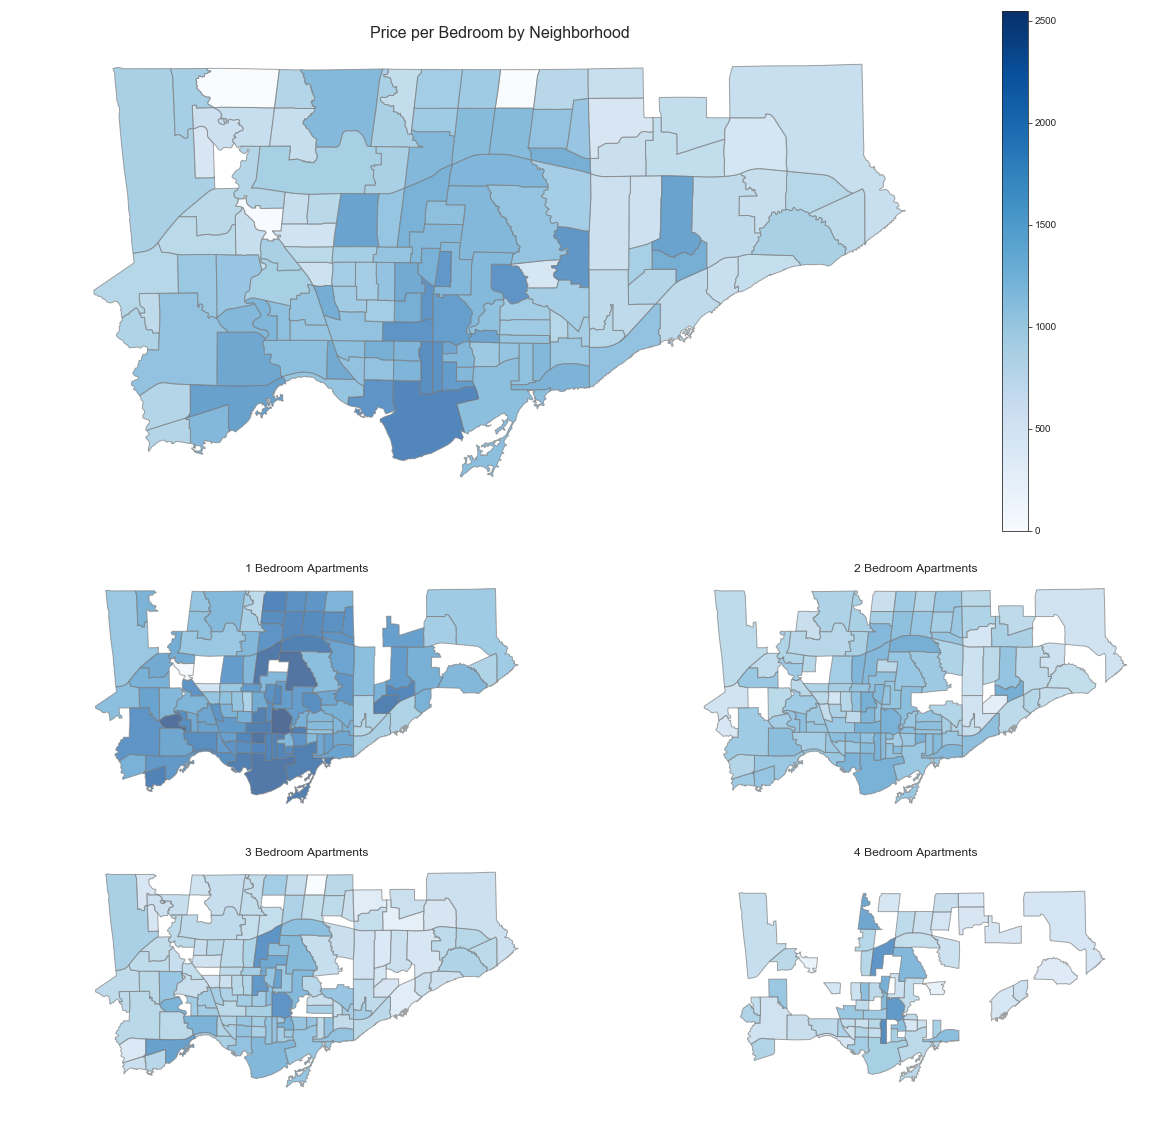

In [483]:
###Set up plot for Price per Bedroom###

#Set gridsize and figure
gridsize = (4, 2)

fig = plt.figure(figsize=(20,20))

#establish consistent scale for all plots
scale_min = np.min(map_df2.ppbrm)
scale_max = np.max(map_df2.ppbrm)

#Set up axes - main plot being the "all bedroom" plot, with subplots for 1,2,etc bedrooms
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid(gridsize, (2, 0))
ax3 = plt.subplot2grid(gridsize, (2, 1))
ax4 = plt.subplot2grid(gridsize, (3, 0))
ax5 = plt.subplot2grid(gridsize, (3, 1))

#Main plot
map_df2[map_df2.listbdrmcount == 'all'].plot(ax = ax1, vmin= scale_min, vmax = scale_max, column = 'ppbrm',edgecolor = 'grey',alpha = 0.7,cmap='Blues', legend = True)
plt.xlim(xlim)
plt.ylim(ylim)
ax1.axis('off')
ax1.set_title('Price per Bedroom by Neighborhood',fontsize=16)

#filtered for 1-4 bedroom plots
map_df2[map_df2.listbdrmcount == 1].plot(ax = ax2, vmin= scale_min, vmax = scale_max, column = 'ppbrm',edgecolor = 'grey',alpha = 0.7,cmap='Blues')
plt.xlim(xlim)
plt.ylim(ylim)
ax2.axis('off')
ax2.set_title('1 Bedroom Apartments',fontsize = 12)

map_df2[map_df2.listbdrmcount == 2].plot(ax = ax3, vmin= scale_min, vmax = scale_max, column = 'ppbrm',edgecolor = 'grey',alpha = 0.7,cmap='Blues')
plt.xlim(xlim)
plt.ylim(ylim)
ax3.axis('off')
ax3.set_title('2 Bedroom Apartments',fontsize = 12)
                       
map_df2[map_df2.listbdrmcount == 3].plot(ax = ax4, vmin= scale_min, vmax = scale_max, column = 'ppbrm',edgecolor = 'grey',alpha = 0.7,cmap='Blues')
plt.xlim(xlim)
plt.ylim(ylim)
ax4.axis('off')
ax4.set_title('3 Bedroom Apartments',fontsize = 12)
                       
map_df2[map_df2.listbdrmcount == 4].plot(ax = ax5, vmin= scale_min, vmax = scale_max, column = 'ppbrm',edgecolor = 'grey',alpha = 0.7,cmap='Blues')
plt.xlim(xlim)
plt.ylim(ylim)
ax5.axis('off')
ax5.set_title('4 Bedroom Apartments',fontsize = 12)


plt.show()

### Text Analysis   
 - Analyze the sentiment scores for different price ranges
 - See common word use by price ranges

In [484]:
#filter dataframe for only instances with text captured
df2 = df.loc[df['body_cln'].notnull()]
df2=df2.drop(columns=['Unnamed: 0'], axis=1)
df2 = df2.reset_index()
print(df2.shape)

(4009, 21)


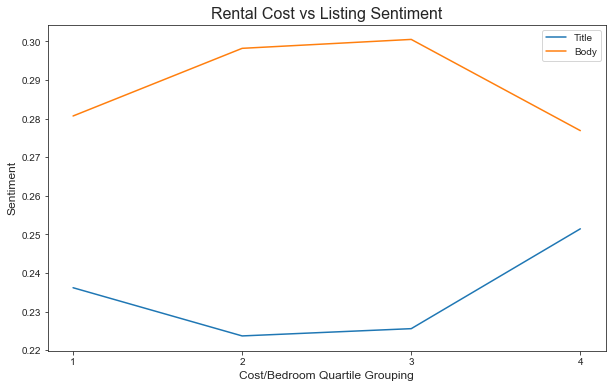

In [485]:
#group price/bedroom into 4 groups (1-4)
df2['cost_grp'] = pd.qcut(df2.ppbrm, 4, labels=[1,2,3,4]).astype('category')
tmp = pd.DataFrame(df2.groupby(['cost_grp'], as_index=False)['title_snt','body_snt'].mean())

sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
sns.lineplot(data=tmp,x = 'cost_grp', y = 'title_snt',label='Title')
sns.lineplot(data=tmp,x = 'cost_grp', y = 'body_snt', label = 'Body')
plt.xticks(np.arange(1,4.5, 1))

plt.xlabel('Cost/Bedroom Quartile Grouping',fontsize = 12)
plt.ylabel('Sentiment',fontsize = 12)
plt.title('Rental Cost vs Listing Sentiment', fontsize = 16)
plt.show()

no strong correlation / trend among quartile intervals. Lets look at scatterplots

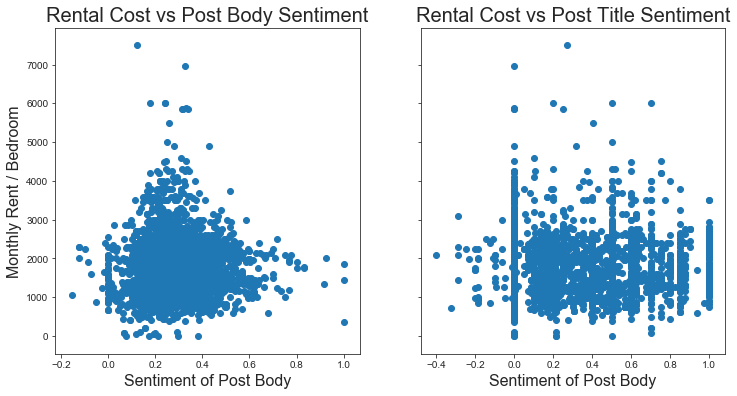

In [486]:
#Scatterplots for Sentiment
sns.set_style('ticks')
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(12,6))

plt.sca(ax1)
plt.scatter( data = df2 , x = 'body_snt', y = 'ppbrm')
plt.xlabel('Sentiment of Post Body',fontsize=16)
plt.ylabel('Monthly Rent / Bedroom',fontsize=16)
plt.title('Rental Cost vs Post Body Sentiment', fontsize = 20)

plt.sca(ax2)
plt.scatter( data = df2 , x = 'title_snt', y = 'ppbrm')
plt.xlabel('Sentiment of Post Body',fontsize=16)
plt.title('Rental Cost vs Post Title Sentiment', fontsize = 20)


plt.show()

From the above, there's no obvious correlation between sentiment of post body/title and monthly rent/bedroom. 

In [487]:
#Ensure "word bag" columns are stored as lists, not a string of a list
from ast import literal_eval
df2.body_cln = list(map(literal_eval, df2.body_cln))
df2.title_cln = list(map(literal_eval, df2.title_cln))

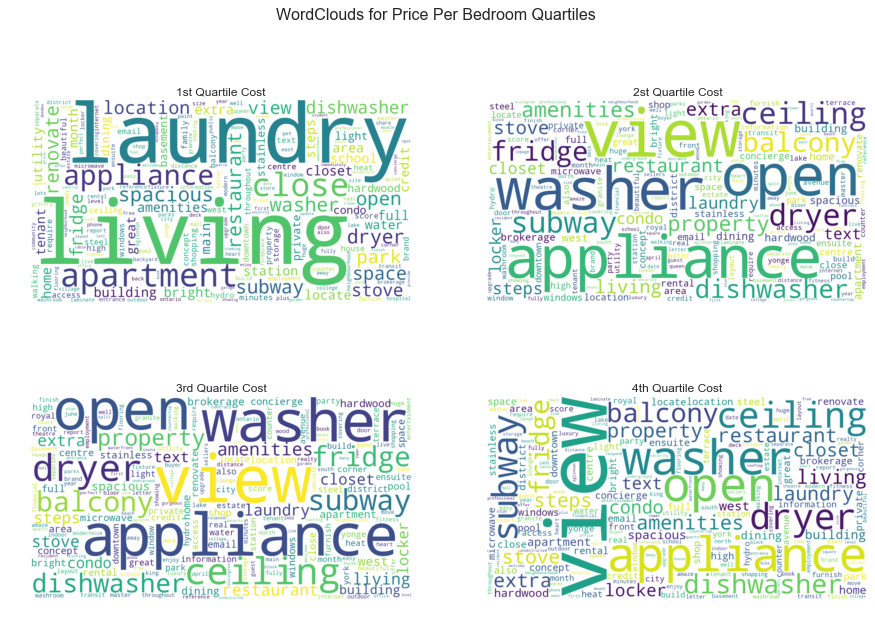

In [496]:
##Common word use by price range
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter

#Tried storing all groupings in a list of lists, but it wouldn't parse. Opt for separate variables
tmp = df2.groupby(['cost_grp'])['body_cln'].apply(list)

#I Tried storing all groupings in a list of lists, but it wouldn't parse in the wordcloud. Opt for separate variables
grp1 = [val for sublist in tmp[1] for val in sublist]
grp2= [val for sublist in tmp[2] for val in sublist]
grp3 = [val for sublist in tmp[3] for val in sublist]
grp4 = [val for sublist in tmp[4] for val in sublist]
  

###Build Wordcloud Plots
sns.set_style('ticks')
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(15,10))


plt.sca(ax1)
word_cloud_dict=Counter(grp1)
wordcloud = WordCloud(background_color="white",width = 1500, height = 800).generate_from_frequencies(word_cloud_dict)
# # Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('1st Quartile Cost', fontsize = 12)

plt.sca(ax2)
word_cloud_dict=Counter(grp2)
wordcloud = WordCloud(background_color="white",width = 1500, height = 800).generate_from_frequencies(word_cloud_dict)
# # Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('2st Quartile Cost', fontsize = 12)


plt.sca(ax3)
word_cloud_dict=Counter(grp2)
wordcloud = WordCloud(background_color="white",width = 1500, height = 800).generate_from_frequencies(word_cloud_dict)
# # Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('3rd Quartile Cost', fontsize = 12)

plt.sca(ax4)
word_cloud_dict=Counter(grp2)
wordcloud = WordCloud(background_color="white",width = 1500, height = 800).generate_from_frequencies(word_cloud_dict)
# # Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('4th Quartile Cost', fontsize = 12)

fig.suptitle('WordClouds for Price Per Bedroom Quartiles', fontsize=16)

plt.show()


Notable items not prominent in the 1st quartile cost include: view, ceiling, open and dryer. The higher tier listings are likely boasting about their view, open spaces, and high ceilings. 

'Balcony' seems to have increasing prominence through the 3 tiers, as well as 'open'.

The 4th tier has 'subway' as a common word, which is likely mentions of proximity to subway. 

The 3-4th tiers note 'appliance' more than the 1st tier does, which is likely to emphasize quality appliances in the higher cost units. 

tiers 2-4 both have prominence in washer & dryer, while the 1st quartile has high prominence to 'laundry' - which could be "in building laundry' vs 'in suite washer/drier'. thish is just a guess though, as it's interesting that one is emphasized over the other. 



### Simply Analytics Data
Import median household income, area population, and # of households

In [489]:
#Import simply analytics data & map

fp = 'SimplyAnalytics_Shapefiles\SimplyAnalytics_Shapefiles_2019-04-22_17_39_41_4f6cb5f6a3723a126aa3cae19027a2f8.shp'

smply_map = gpd.read_file(fp)
print(smply_map.crs)
smply_map.dropna(subset=['geometry'],inplace=True)

#Generate GDF with data and perform same manipulations as other map/gdf
smply_map['geometry'] = smply_map['geometry'].to_crs({'init':'epsg:2019'})
smply_map['geometry']=smply_map['geometry'].rotate(angle = -17, origin=(315000,4840000), use_radians=False)
smply_map.head()

{'init': 'epsg:4326'}


spatial_id                    name  VALUE0  VALUE1    VALUE2  \
0  5350001.00  CT0001.00, Toronto, ON   249.0   600.0  79727.91   
1  5350002.00  CT0002.00, Toronto, ON   267.0   613.0  74505.79   
2  5350003.00  CT0003.00, Toronto, ON   537.0  1557.0  88073.28   
3  5350004.00  CT0004.00, Toronto, ON  3712.0  7177.0  27670.45   
4  5350005.00  CT0005.00, Toronto, ON  3722.0  6969.0  33807.26   

                                            geometry  
0  POLYGON ((318940.2800649307 4833457.91512259, ...  
1  POLYGON ((314588.0646663511 4831792.600943465,...  
2  POLYGON ((308088.9250427303 4834184.672469976,...  
3  POLYGON ((308080.408829724 4834598.619100569, ...  
4  POLYGON ((309089.6757757317 4834741.552257465,...

In [490]:
#overwrite columns with relevant data names
smply_map.columns = ['spatial_id', 'name', '#Households', 'Population', 'MedIncome', 'geometry']

smply_map['density'] = smply_map['Population']/smply_map['#Households']

gdf2 = gpd.sjoin(gdf, smply_map, op='within') 
gdf2.head()

Unnamed: 0    area  bedrooms             datetime   price  \
0          14418  1300.0       3.0  2019-03-19 08:35:00  2550.0   
655        13703     NaN       2.0  2019-03-25 12:30:00  4599.0   
2053       10541     NaN       3.0  2019-04-01 16:34:00  4900.0   
2191        8764     NaN       3.0  2019-04-02 08:13:00  5200.0   
2852        2935     NaN       3.0  2019-04-04 21:17:00  5200.0   

                                                    url      latitude  \
0                                                   NaN  4.835410e+06   
655                                                 NaN  4.834905e+06   
2053  https://toronto.craigslist.org/tor/apa/d/toron...  4.834927e+06   
2191  https://toronto.craigslist.org/tor/apa/d/toron...  4.835268e+06   
2852  https://toronto.craigslist.org/tor/apa/d/toron...  4.835268e+06   

          longitude  outlier        ppbrm  ...  studio listbdrm  \
0     320382.071310    False   850.000000  ...   False      3.0   
655   319930.029866    False  2299.500000  ...   False      2.0   
2053  319810.122037    False  1633.333333  ...   False      3.0   
2191  320142.158920    False  1733.333333  ...   False      3.0   
2852  320142.158920    False  1733.333333  ...   False      3.0   

                                      coordinates index_right  spatial_id  \
0     POINT (320382.0713095986 4835409.694091788)          32  5350023.00   
655    POINT (319930.0298659585 4834904.50646494)          32  5350023.00   
2053    POINT (319810.1220374792 4834927.0320011)          32  5350023.00   
2191  POINT (320142.1589203335 4835268.336497908)          32  5350023.00   
2852  POINT (320142.1589203335 4835268.336497908)          32  5350023.00   

                        name  #Households  Population  MedIncome   density  
0     CT0023.00, Toronto, ON       1377.0      3448.0  133948.71  2.503994  
655   CT0023.00, Toronto, ON       1377.0      3448.0  133948.71  2.503994  
2053  CT0023.00, Toronto, ON       1377.0      3448.0  133948.71  2.503994  
2191  CT0023.00, Toronto, ON       1377.0      3448.0  133948.71  2.503994  
2852  CT0023.00, Toronto, ON       1377.0      3448.0  133948.71  2.503994  

[5 rows x 28 columns]

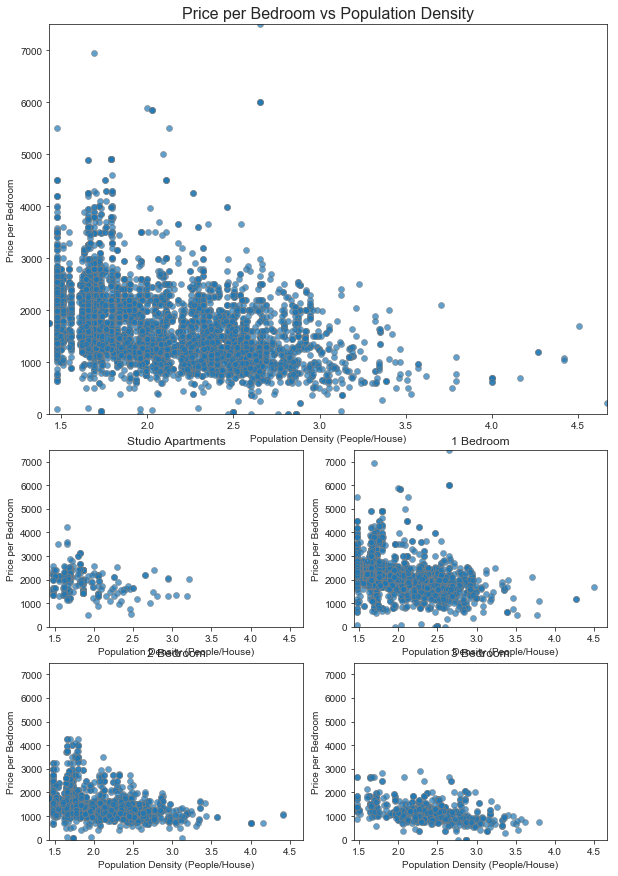

In [491]:
###Set up plot for Price per Bedroom vs Population Density###

xlim = [np.min(gdf2.density),np.max(gdf2.density)]
ylim = [np.min(gdf2.ppbrm),np.max(gdf2.ppbrm)]

#Set gridsize and figure
gridsize = (4, 2)

fig = plt.figure(figsize=(10,15))

#Set up axes - main plot being the "all bedroom" plot, with subplots for 1,2,etc bedrooms
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid(gridsize, (2, 0))
ax3 = plt.subplot2grid(gridsize, (2, 1))
ax4 = plt.subplot2grid(gridsize, (3, 0))
ax5 = plt.subplot2grid(gridsize, (3, 1))

#Main plot
plt.sca(ax1)
sns.scatterplot(ax = ax1,data =gdf2,  x = 'density', y= 'ppbrm', edgecolor = 'grey',alpha = 0.7,cmap='Blues')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel('Population Density (People/House)')
plt.ylabel('Price per Bedroom')
ax1.set_title('Price per Bedroom vs Population Density',fontsize=16)

# #filtered for studio - 3 bedroom plots
plt.sca(ax2)
sns.scatterplot(ax = ax2,data =gdf2[gdf2.listbdrm == 0],  x = 'density', y= 'ppbrm', edgecolor = 'grey',alpha = 0.7,cmap='Blues')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel('Population Density (People/House)')
plt.ylabel('Price per Bedroom')
ax2.set_title('Studio Apartments',fontsize=12)

plt.sca(ax3)
sns.scatterplot(ax = ax3,data =gdf2[gdf2.listbdrm == 1],  x = 'density', y= 'ppbrm', edgecolor = 'grey',alpha = 0.7,cmap='Blues')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel('Population Density (People/House)')
plt.ylabel('Price per Bedroom')
ax3.set_title('1 Bedroom',fontsize=12)

plt.sca(ax4)
sns.scatterplot(ax = ax4,data =gdf2[gdf2.listbdrm == 2],  x = 'density', y= 'ppbrm', edgecolor = 'grey',alpha = 0.7,cmap='Blues')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel('Population Density (People/House)')
plt.ylabel('Price per Bedroom')
ax4.set_title('2 Bedroom',fontsize=12)


plt.sca(ax5)
sns.scatterplot(ax = ax5,data =gdf2[gdf2.listbdrm == 3],  x = 'density', y= 'ppbrm', edgecolor = 'grey',alpha = 0.7,cmap='Blues')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel('Population Density (People/House)')
plt.ylabel('Price per Bedroom')
ax5.set_title('3 Bedroom',fontsize=12)


plt.show()

A moderate negative correlation indicates that people seem to pay a premium to live in lower density areas. 

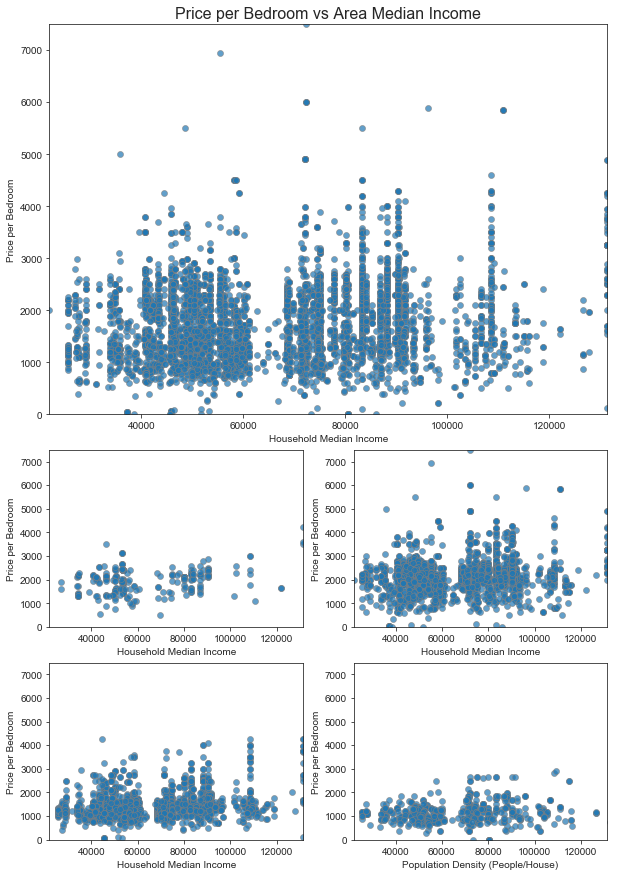

In [492]:
###Set up plot for Price per Bedroom vs Median Income###

xlim = [np.min(gdf2.MedIncome),np.percentile(gdf2.MedIncome,98)]
ylim = [np.min(gdf2.ppbrm),np.max(gdf2.ppbrm)]

#Set gridsize and figure
gridsize = (4, 2)

fig = plt.figure(figsize=(10,15))

#Set up axes - main plot being the "all bedroom" plot, with subplots for 1,2,etc bedrooms
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid(gridsize, (2, 0))
ax3 = plt.subplot2grid(gridsize, (2, 1))
ax4 = plt.subplot2grid(gridsize, (3, 0))
ax5 = plt.subplot2grid(gridsize, (3, 1))

#Main plot
plt.sca(ax1)
sns.scatterplot(ax = ax1,data =gdf2,  x = 'MedIncome', y= 'ppbrm', edgecolor = 'grey',alpha = 0.7,cmap='Blues')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel('Household Median Income')
plt.ylabel('Price per Bedroom')
ax1.set_title('Price per Bedroom vs Area Median Income',fontsize=16)

# #filtered for studio - 3 bedroom plots
plt.sca(ax2)
sns.scatterplot(ax = ax2,data =gdf2[gdf2.listbdrm == 0],  x = 'MedIncome', y= 'ppbrm', edgecolor = 'grey',alpha = 0.7,cmap='Blues')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel('Household Median Income')
plt.ylabel('Price per Bedroom')


plt.sca(ax3)
sns.scatterplot(ax = ax3,data =gdf2[gdf2.listbdrm == 1],  x = 'MedIncome', y= 'ppbrm', edgecolor = 'grey',alpha = 0.7,cmap='Blues')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel('Household Median Income')
plt.ylabel('Price per Bedroom')


plt.sca(ax4)
sns.scatterplot(ax = ax4,data =gdf2[gdf2.listbdrm == 2],  x = 'MedIncome', y= 'ppbrm', edgecolor = 'grey',alpha = 0.7,cmap='Blues')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel('Household Median Income')
plt.ylabel('Price per Bedroom')


plt.sca(ax5)
sns.scatterplot(ax = ax5,data =gdf2[gdf2.listbdrm == 3],  x = 'MedIncome', y= 'ppbrm', edgecolor = 'grey',alpha = 0.7,cmap='Blues')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel('Population Density (People/House)')
plt.ylabel('Price per Bedroom')


plt.show()

No visual trend / correlation

## Model Building
Though there seems to be few notable correlations between features, try to build a model to see how accurate it could be

In [493]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score, cross_val_predict

In [494]:
list(gdf2)

['Unnamed: 0',
 'area',
 'bedrooms',
 'datetime',
 'price',
 'url',
 'latitude',
 'longitude',
 'outlier',
 'ppbrm',
 'ppsqft',
 'title_txt',
 'body_txt',
 'title_cln',
 'body_cln',
 'title_snt',
 'body_snt',
 'basement',
 'studio',
 'listbdrm',
 'coordinates',
 'index_right',
 'spatial_id',
 'name',
 '#Households',
 'Population',
 'MedIncome',
 'density']

In [495]:
df_model = gdf2[[
#  'Unnamed: 0',
 'area',
 'bedrooms',
#  'datetime',
 'price',
#  'url',
 'latitude',
 'longitude',
#  'outlier',
#  'ppbrm',
#  'ppsqft',
#  'title_txt',
#  'body_txt',
#  'title_cln',
#  'body_cln',
#  'title_snt',
#  'body_snt',
 'basement',
 'studio',
 'listbdrm',
#  'coordinates',
#  'index_right',
#  'spatial_id',
#  'name',
#  '#Households',
#  'Population',
 'MedIncome',
 'density']]

In [443]:
df_model.isna().sum()

area         3295
bedrooms      592
price           0
latitude        0
longitude       0
basement        0
studio          0
listbdrm      456
MedIncome       0
density         0
dtype: int64

In [444]:
#As most of the missing data is in the area column, which we'd like to leverage for the analysis,
#the quickest thing to do is just drop all NA. 
#With more time, attempt to extract area from the posting body 

x=len(df_model)
df_model=df_model.dropna()
print(x-len(df_model), 'Dropped rows')

3473 Dropped rows


In [445]:
target = df_model['price']
df_model=df_model.drop(['price'],axis=1)

df_model.dtypes

area         float64
bedrooms     float64
latitude     float64
longitude    float64
basement        bool
studio          bool
listbdrm     float64
MedIncome    float64
density      float64
dtype: object

In [451]:
df_model.listbdrm = df_model.listbdrm.astype(int)
df_model.bedrooms= df_model.bedrooms.astype(int)
df_model.area= df_model.area.astype(int)
df_model.dtypes

pandas.core.series.Series

In [452]:
#Linear Regression
y = target
X = df_model

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

reg = LinearRegression().fit(X_train, y_train)
print(reg.score(X_test, y_test))


0.45122216348974575


In [453]:
#Decision Tree

DT1 = DecisionTreeRegressor(random_state=0)
DT1.fit(X_train, y_train)

print(DT1.score(X_test,y_test))

0.45715325953581076


In [463]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(DT1, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

InvocationException: GraphViz's executables not found

In [454]:
RFR = RandomForestRegressor(random_state=0, n_estimators=100)
RFR.fit(X_train, y_train)
print(RFR.score(X_test, y_test))
print(RFR.feature_importances_)

0.6255335426453819
[0.49414874 0.04550097 0.12251245 0.09592498 0.00529932 0.00115407
 0.0096758  0.06609524 0.15968842]
